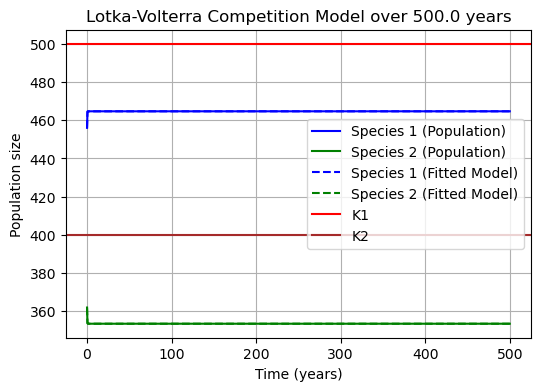

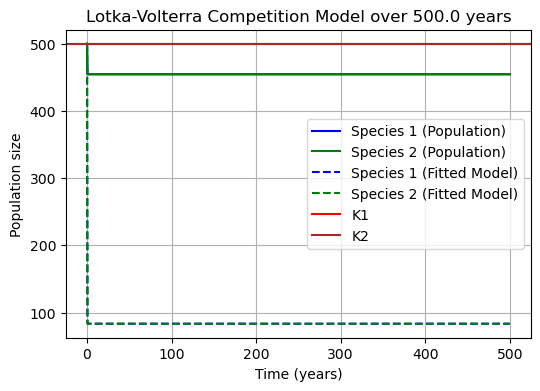

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from scipy.optimize import curve_fit
import tkinter as tk
from tkinter import ttk, messagebox
from matplotlib.backends.backend_tkagg import FigureCanvasTkAgg

# Define the Lotka-Volterra competition model
def lotka_volterra(N, t, r1, r2, K1, K2, alpha, beta):
    N1, N2 = N
    dN1dt = r1 * N1 * (1 - (N1 + alpha * N2) / K1)
    dN2dt = r2 * N2 * (1 - (N2 + beta * N1) / K2)
    return [dN1dt, dN2dt]

# Function to solve the differential equations
def solve_lv(t, N0, r1, r2, K1, K2, alpha, beta):
    return odeint(lotka_volterra, N0, t, args=(r1, r2, K1, K2, alpha, beta)).T

# Function to fit the model to data
def fit_lv(t, N1, N2, r1, r2, K1, K2):
    def model(t, alpha, beta):
        N = solve_lv(t, [N1[0], N2[0]], r1, r2, K1, K2, alpha, beta)
        return np.concatenate((N[0], N[1]))
    
    popt, _ = curve_fit(model, t, np.concatenate((N1, N2)), bounds=(0, [10, 10]))
    alpha, beta = popt
    return alpha, beta

# Function to run the simulation and plot the results
def run_simulation():
    try:
        N1_initial = float(entry_N1.get())
        N2_initial = float(entry_N2.get())
        r1 = float(entry_r1.get())
        r2 = float(entry_r2.get())
        K1 = float(entry_K1.get())
        K2 = float(entry_K2.get())
        duration = float(entry_duration.get())
    except ValueError:
        messagebox.showerror("Input Error", "Please enter valid numerical values")
        return

    # Generate time points based on the duration
    time_points = 1000  # Increase time points for smoother plots
    t = np.linspace(0, duration, time_points)

    # Initial populations
    N0 = [N1_initial, N2_initial]

    # Fit the model to estimate alpha and beta
    synthetic_data = solve_lv(t, N0, r1, r2, K1, K2, 0.1, 0.1)
    alpha, beta = fit_lv(t, synthetic_data[0], synthetic_data[1], r1, r2, K1, K2)

    # Predict who will win based on K1/alpha and K2/beta
    K1_over_alpha = K1 / alpha
    K2_over_beta = K2 / beta
    if K1_over_alpha > K2_over_beta:
        winner = "Species 1"
    elif K1_over_alpha < K2_over_beta:
        winner = "Species 2"
    else:
        winner = "Neither (Stable coexistence or unstable equilibrium)"

    # Display results
    result_text.set(f"Estimated alpha: {alpha}\n"
                    f"Estimated beta: {beta}\n"
                    f"K1/alpha: {K1_over_alpha}\n"
                    f"K2/beta: {K2_over_beta}\n"
                    f"Predicted winner: {winner}")

    # Plot the results with corrected dynamics
    fig, ax = plt.subplots(figsize=(6, 4))
    ax.plot(t, synthetic_data[0], label='Species 1 (Population)', color='blue')
    ax.plot(t, synthetic_data[1], label='Species 2 (Population)', color='green')

    fitted_data = solve_lv(t, N0, r1, r2, K1, K2, alpha, beta)
    ax.plot(t, fitted_data[0], '--', label='Species 1 (Fitted Model)', color='blue')
    ax.plot(t, fitted_data[1], '--', label='Species 2 (Fitted Model)', color='green')

    ax.axhline(y=K1, color='red', linestyle='-', label='K1')
    ax.axhline(y=K2, color='brown', linestyle='-', label='K2')

    ax.set_xlabel('Time (years)')
    ax.set_ylabel('Population size')
    ax.set_title(f'Lotka-Volterra Competition Model over {duration} years')
    ax.legend()
    ax.grid(True)

    # Embed the plot in the Tkinter window
    canvas = FigureCanvasTkAgg(fig, master=frame)
    canvas.draw()
    canvas.get_tk_widget().grid(row=9, column=0, columnspan=2)

# Create the GUI
root = tk.Tk()
root.title("Lotka-Volterra Competition Model")

frame = ttk.Frame(root, padding="10")
frame.grid(row=0, column=0, sticky=(tk.W, tk.E, tk.N, tk.S))

# Input fields
ttk.Label(frame, text="Initial population of species 1 (N1):").grid(row=0, column=0, sticky=tk.W)
entry_N1 = ttk.Entry(frame)
entry_N1.grid(row=0, column=1)

ttk.Label(frame, text="Initial population of species 2 (N2):").grid(row=1, column=0, sticky=tk.W)
entry_N2 = ttk.Entry(frame)
entry_N2.grid(row=1, column=1)

ttk.Label(frame, text="Growth rate of species 1 (r1):").grid(row=2, column=0, sticky=tk.W)
entry_r1 = ttk.Entry(frame)
entry_r1.grid(row=2, column=1)

ttk.Label(frame, text="Growth rate of species 2 (r2):").grid(row=3, column=0, sticky=tk.W)
entry_r2 = ttk.Entry(frame)
entry_r2.grid(row=3, column=1)

ttk.Label(frame, text="Carrying capacity of species 1 (K1):").grid(row=4, column=0, sticky=tk.W)
entry_K1 = ttk.Entry(frame)
entry_K1.grid(row=4, column=1)

ttk.Label(frame, text="Carrying capacity of species 2 (K2):").grid(row=5, column=0, sticky=tk.W)
entry_K2 = ttk.Entry(frame)
entry_K2.grid(row=5, column=1)

ttk.Label(frame, text="Duration of competition (years):").grid(row=6, column=0, sticky=tk.W)
entry_duration = ttk.Entry(frame)
entry_duration.grid(row=6, column=1)

# Run button
run_button = ttk.Button(frame, text="Run Simulation", command=run_simulation)
run_button.grid(row=7, column=0, columnspan=2)

# Result display
result_text = tk.StringVar()
ttk.Label(frame, textvariable=result_text).grid(row=8, column=0, columnspan=2)

root.mainloop()